# Adam Optimization Method

Adam Opimizer: <b>Adaptive Moment Estimation</b>

$$m_t = \beta_1 m_{t-1} + (1-\beta_1)g_t$$
$$v_t=\beta_2 v_{t-1} + (1-\beta_2) g_t^2$$

There is a bias towards zero, so we compute bias corrected versions:

$$\hat{m}_t = \frac{m_t}{1-\beta_1^t}$$
$$\hat{v}_t = \frac{v_t}{1-\beta_2^t}$$

Then update the parameters via:

$$\theta_{t+1}=\theta_t - \frac{\eta}{\sqrt{\hat{v}_t} + \epsilon}\hat{m}_t$$

# Loading Data

In [1]:
import os
import numpy as np
from PIL import Image
from matplotlib import pyplot

In [2]:
data_dir = "/home/ponl/Projects/data/Massachusetts/data/mass_buildings/train/sat"

In [3]:
fls = [fl for fl in os.listdir(data_dir) if fl.endswith("tiff")]
fls = [os.path.join(data_dir, fl) for fl in fls]

print(f"Found {len(fls)} chips")

Found 137 chips


In [279]:
def load_image(path):
    return np.asarray(Image.open(path), dtype=np.float) / 255.0

def chip_generator(paths, size=64, batch_size=32):
    def get_chip(img):
        while True:
            h, w, c = img.shape
            i = np.random.randint(h-size)
            j = np.random.randint(w-size)
            chip = img[i:(i+size), j:(j+size)]
            if valid_chip(chip):
                return chip
    
    def valid_chip(chip, threshold=0.01):
        b = np.sum(chip < threshold) / chip.size
        w = np.sum(chip > (1-threshold)) / chip.size
        return b < 0.9 and w < 0.9
    
    images = [load_image(p) for p in paths]
    nimg = len(images)
    
    while True:
        randimgs = np.random.randint(0, nimg, size=batch_size)
        yield np.array([get_chip(images[i]) for i in randimgs])

In [280]:
def show_chips(X, num=5, cols=5):
    nrow = num // cols + 1
    ncol = min(num, cols)
    
    pyplot.figure(figsize=(40,nrow*10))
    
    for i in range(num):
        pyplot.subplot(nrow, ncol, i+1)
        x = X[i]
        
        if x.shape[-1] == 1:
            # Grayscale Image
            pyplot.imshow(x[:,:,0], cmap="Greys_r")
        else:
            # Color image
            pyplot.imshow(x)

In [281]:
chip_gen = chip_generator(fls)

In [288]:
X = next(chip_gen)

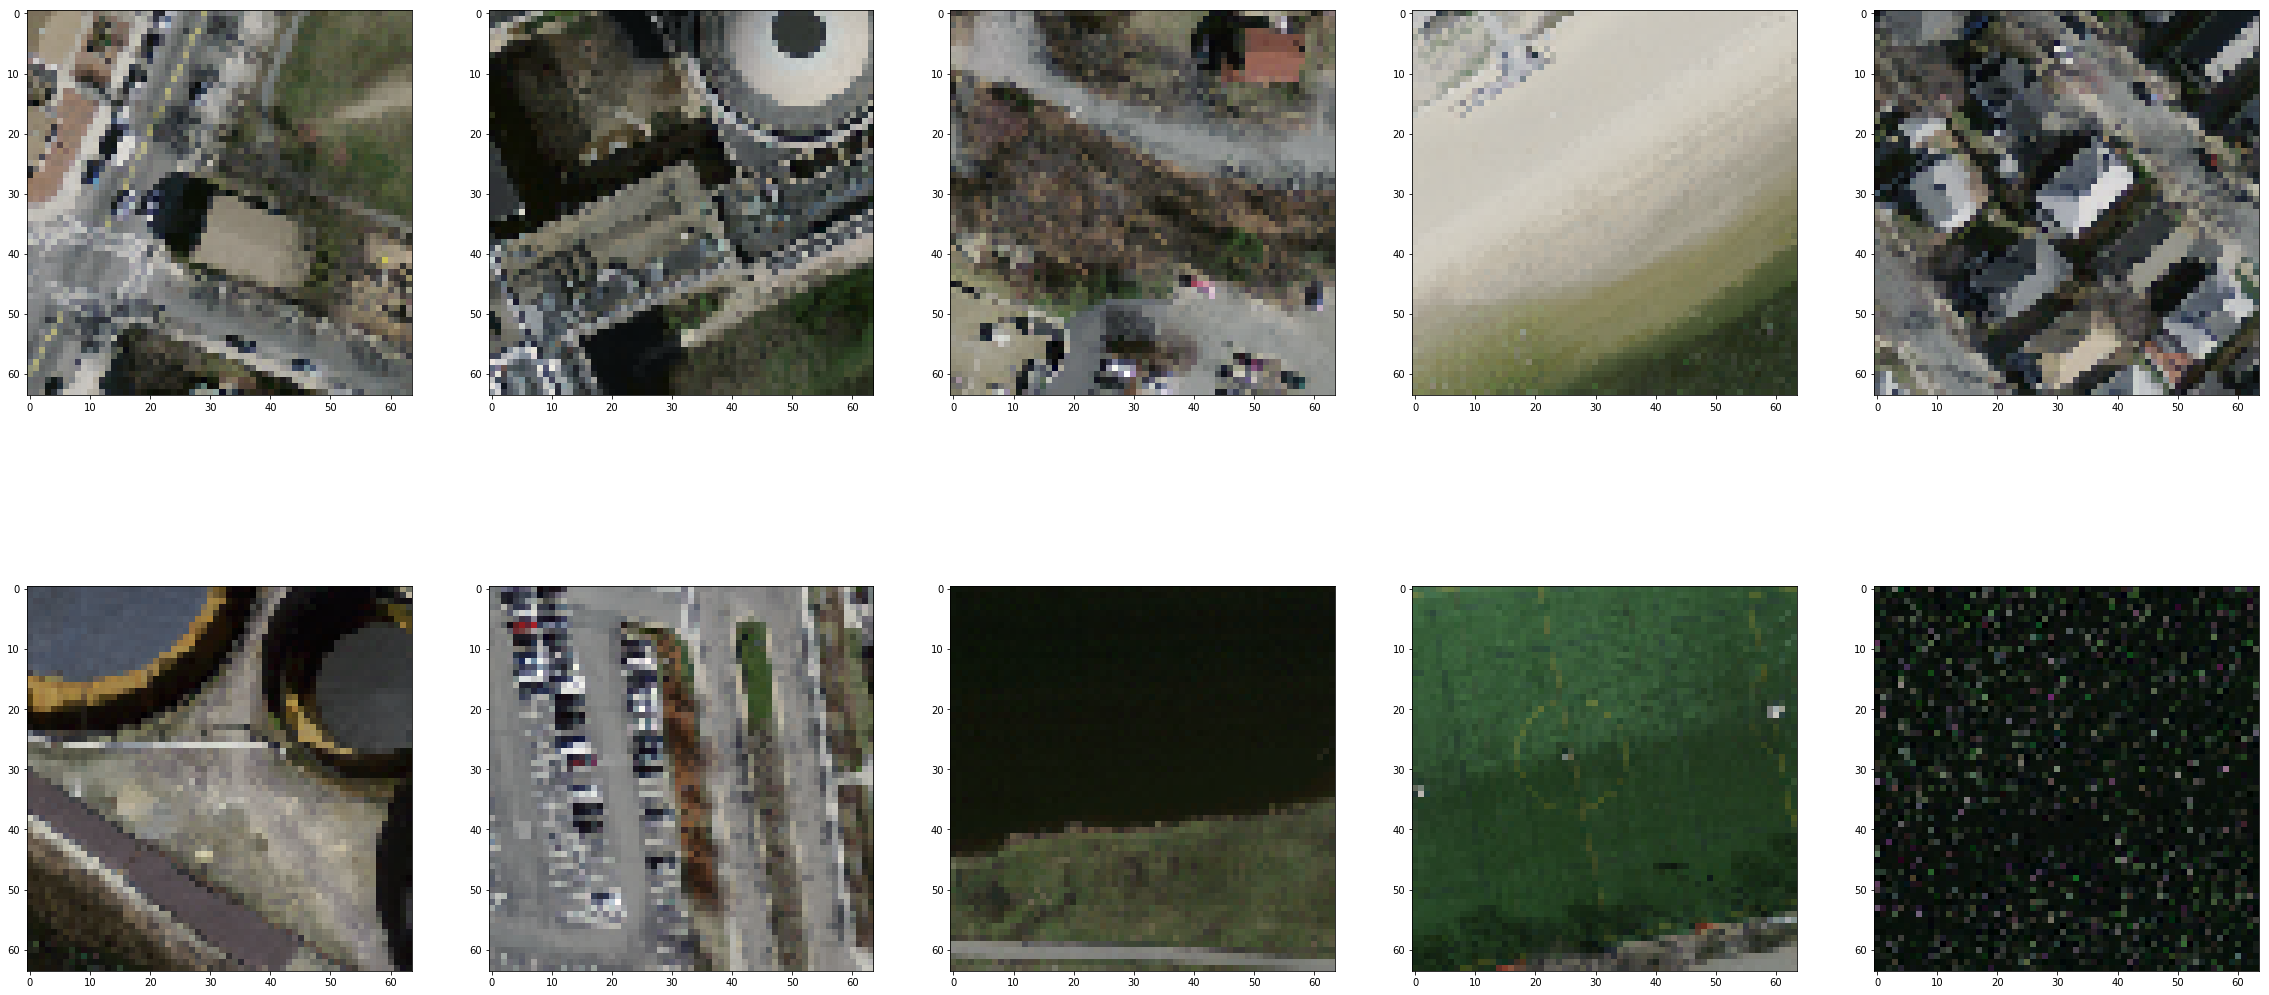

In [289]:
show_chips(X, num=10)

# Convolutional Autoencoder

In [90]:
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Activation

In [91]:
def ConvolutionalAutoencoder(inshape, ifilters=32):
    I = Input(shape=inshape)
    
    x = Conv2D(ifilters, kernel_size=3, padding="same")(I)
    x = Conv2D(ifilters, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Conv2D(ifilters*2, kernel_size=3, padding="same")(x)
    x = Conv2D(ifilters*2, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Conv2D(ifilters*4, kernel_size=3, padding="same")(x)
    x = Conv2D(ifilters*4, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Conv2D(ifilters*8, kernel_size=3, padding="same")(x)
    x = Conv2D(ifilters*8, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    
    x = UpSampling2D()(x)
    x = Conv2D(ifilters*4, kernel_size=3, padding="same")(x)
    x = Conv2D(ifilters*4, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    
    x = UpSampling2D()(x)
    x = Conv2D(ifilters*2, kernel_size=3, padding="same")(x)
    x = Conv2D(ifilters*2, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    
    x = UpSampling2D()(x)
    x = Conv2D(ifilters, kernel_size=3, padding="same")(x)
    x = Conv2D(ifilters, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    
    x = Conv2D(3, kernel_size=1, padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs=I, outputs=x)
    model.compile(loss = "mean_squared_error", optimizer=Adam())
    
    return model

In [92]:
def autoencoder_generator(base_gen):
    for X in base_gen:
        yield X, X

In [93]:
ae_gen = autoencoder_generator(chip_gen)

In [94]:
convae = ConvolutionalAutoencoder(X[0].shape)

In [95]:
convae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 64, 64, 32)        9248      
_________________________________________________________________
activation_65 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_124 (Conv2D)          (None, 32, 32, 64)        36928     
__________

In [295]:
convae.fit_generator(ae_gen, steps_per_epoch=100, epochs=10)

Epoch 1/10
100/100 [==============================] - 2s 23ms/step - loss: 0.0078
Epoch 2/10
100/100 [==============================] - 2s 23ms/step - loss: 0.0078
Epoch 3/10
100/100 [==============================] - 2s 23ms/step - loss: 0.0076
Epoch 4/10
100/100 [==============================] - 2s 23ms/step - loss: 0.0071
Epoch 5/10
100/100 [==============================] - 2s 23ms/step - loss: 0.0070
Epoch 6/10
100/100 [==============================] - 2s 23ms/step - loss: 0.0069
Epoch 7/10
100/100 [==============================] - 2s 23ms/step - loss: 0.0066
Epoch 8/10
100/100 [==============================] - 2s 23ms/step - loss: 0.0067
Epoch 9/10
100/100 [==============================] - 2s 23ms/step - loss: 0.0063
Epoch 10/10
100/100 [==============================] - 2s 23ms/step - loss: 0.0067


In [296]:
Y = convae.predict(X)

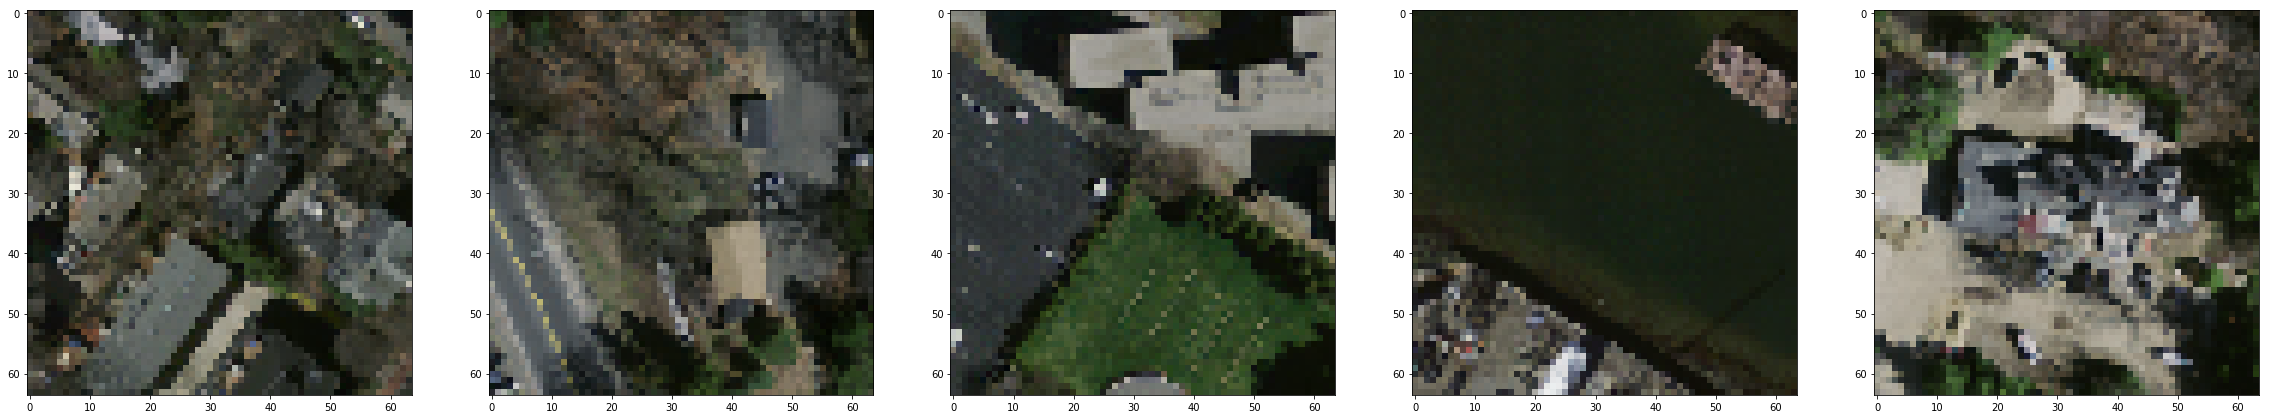

In [297]:
show_chips(X)

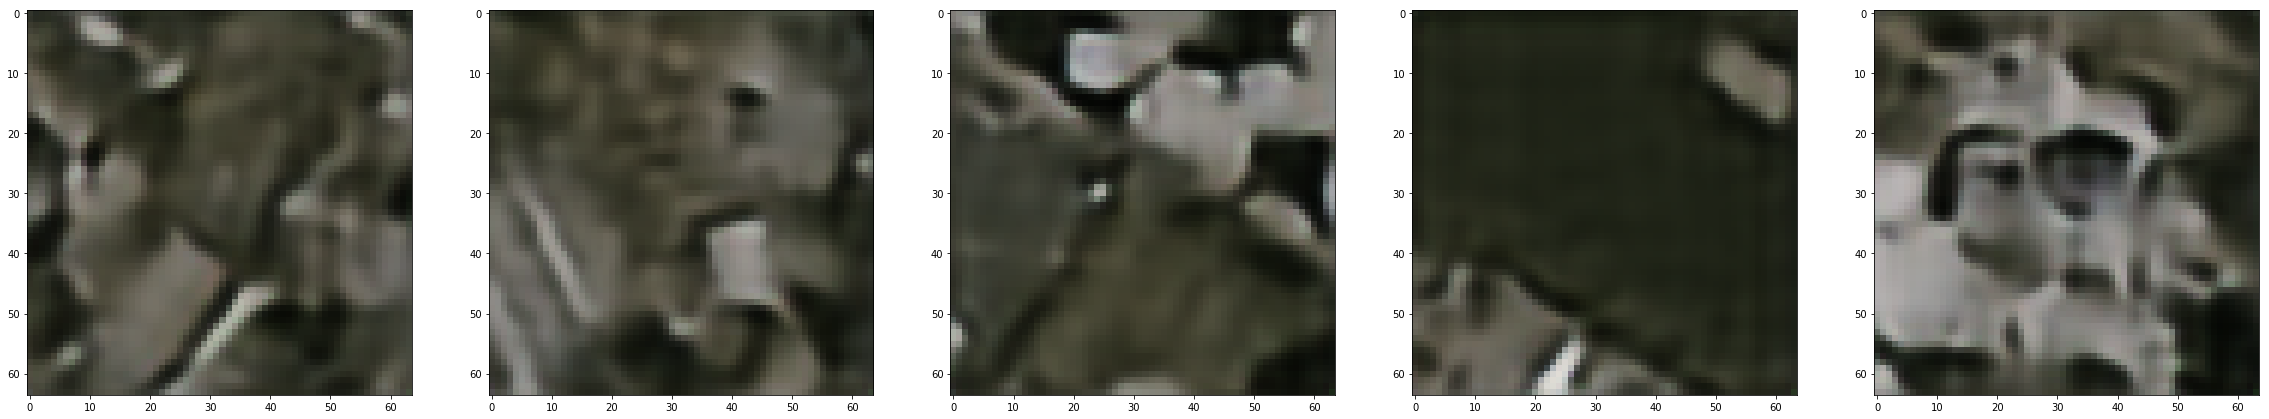

In [298]:
show_chips(Y)

# Resaturation Network

In [136]:
from keras.layers import Concatenate

In [154]:
class UNet(object):
    def __init__(self, inshape):
        self._inshape = inshape
        self.build_model()
        
    def build_model(self, ifilters=32):
        I = Input(shape=self._inshape)
        
        # In: 256x256, Out: 128x128
        x, s0 = UNet.build_block(I, nfilters=ifilters)
        
        # In: 128x128, Out: 64x64
        x, s1 = UNet.build_block(x, nfilters=ifilters * 2)
        
        # In: 64x64, Out: 32x32
        x, s2 = UNet.build_block(x, nfilters=ifilters * 4)
        
        # In: 32x32, Out: 16x16
        x, s3 = UNet.build_block(x, nfilters=ifilters * 8)
        
        # Bottom block
        x, _ = UNet.build_block(x, nfilters=ifilters * 16, pooling=False)
        
        # In: 16x16, Out: 32x32
        x, _ = UNet.build_block(x, skip=s3, nfilters=ifilters * 8)
        
        # In: 32x32, Out: 64x64
        x, _ = UNet.build_block(x, skip=s2, nfilters=ifilters * 4)
        
        # In: 64x64, Out: 128x128
        x, _ = UNet.build_block(x, skip=s1, nfilters=ifilters * 2)
        
        # In: 128x128, Out: 256x256
        x, _ = UNet.build_block(x, skip=s0, nfilters=ifilters)
        
        # Output Layer
        x = Conv2D(3, kernel_size=1, padding="same")(x)
        x = Activation("sigmoid")(x)
        
        # Build the model using I as input and x as output
        self._model = Model(inputs=I, outputs=x)
        
        # Compile the model using binary cross-entropy loss and the Adam optimizer
        self._model.compile(loss="mean_squared_error", optimizer=Adam())
        
    
    @staticmethod
    def build_block(x, skip=None, nfilters=32, pooling=True):
        if skip is not None:
            x = UpSampling2D()(x)
            x = Concatenate()([x, skip])
            
        x = Conv2D(nfilters, kernel_size=3, padding="same")(x)
        x = Activation("relu")(x)
        
        x = Conv2D(nfilters, kernel_size=3, padding="same")(x)
        s = Activation("relu")(x)
        
        if skip is None and pooling:
            x = MaxPool2D()(s)
        else:
            x = s
            
        # Output and skip connection
        return x, s

In [155]:
def resaturation_generator(base_gen):
    for X in base_gen:
        D = np.mean(X, axis=-1)[:,:,:,None]
        yield D, X

In [169]:
rs_gen = resaturation_generator(chip_gen)

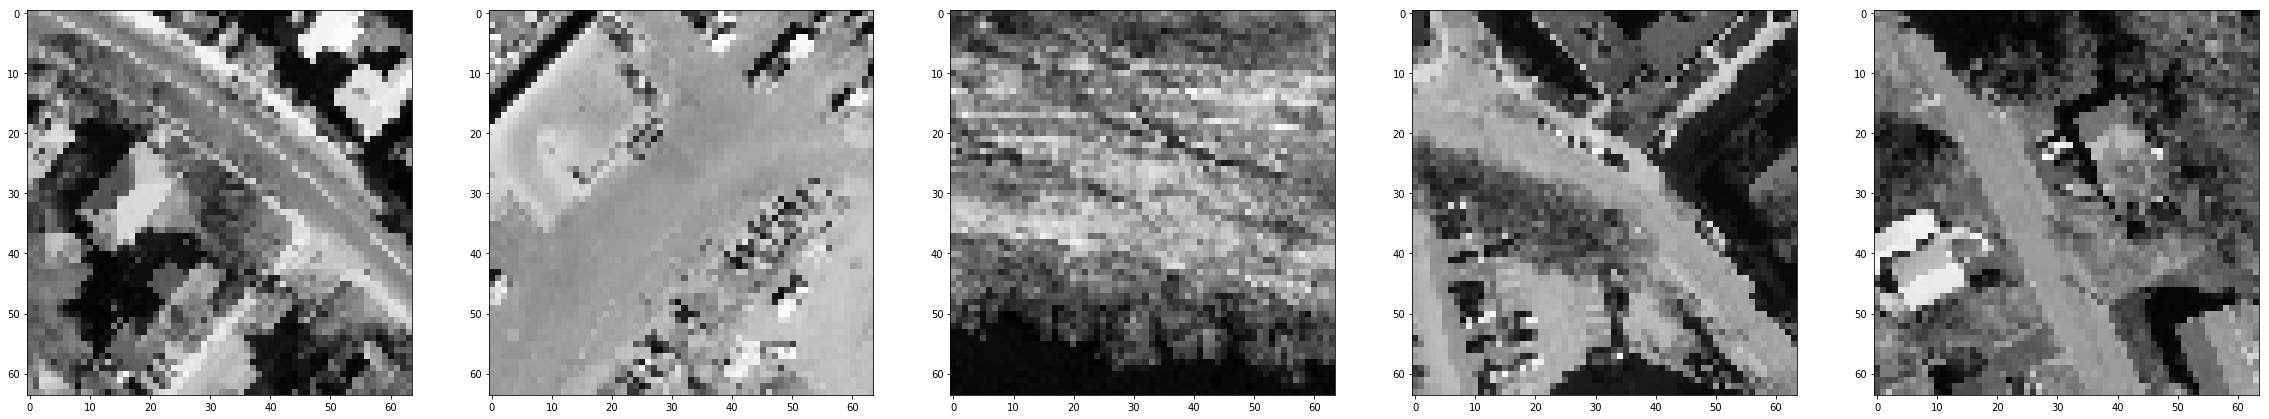

In [170]:
D, X = next(rs_gen)
show_chips(D)

In [171]:
resatnet = UNet(D[0].shape)

In [172]:
resatnet._model.fit_generator(rs_gen, steps_per_epoch=100, epochs=30)

Epoch 1/30
100/100 [==============================] - 7s 66ms/step - loss: 0.0218
Epoch 2/30
100/100 [==============================] - 4s 37ms/step - loss: 0.0033
Epoch 3/30
100/100 [==============================] - 4s 36ms/step - loss: 0.0014
Epoch 4/30
100/100 [==============================] - 4s 36ms/step - loss: 9.3233e-04
Epoch 5/30
100/100 [==============================] - 4s 37ms/step - loss: 8.2674e-04
Epoch 6/30
100/100 [==============================] - 4s 37ms/step - loss: 8.8596e-04
Epoch 7/30
100/100 [==============================] - 4s 36ms/step - loss: 7.3954e-04
Epoch 8/30
100/100 [==============================] - 4s 36ms/step - loss: 7.1440e-04
Epoch 9/30
100/100 [==============================] - 4s 37ms/step - loss: 6.9707e-04
Epoch 10/30
100/100 [==============================] - 4s 36ms/step - loss: 6.9203e-04
Epoch 11/30
100/100 [==============================] - 4s 37ms/step - loss: 6.9257e-04
Epoch 12/30
100/100 [==============================] - 4s 37ms/s

In [290]:
D, X = next(rs_gen)

In [291]:
S = resatnet._model.predict(D)

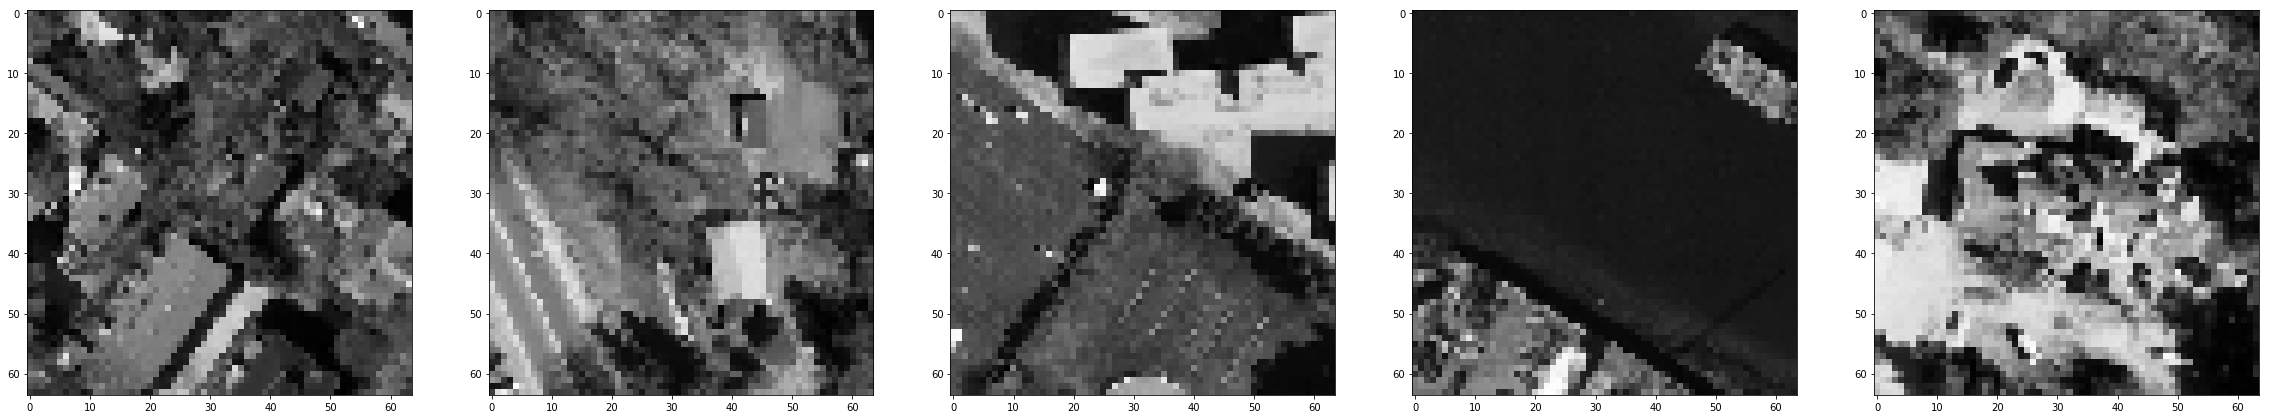

In [292]:
show_chips(D)

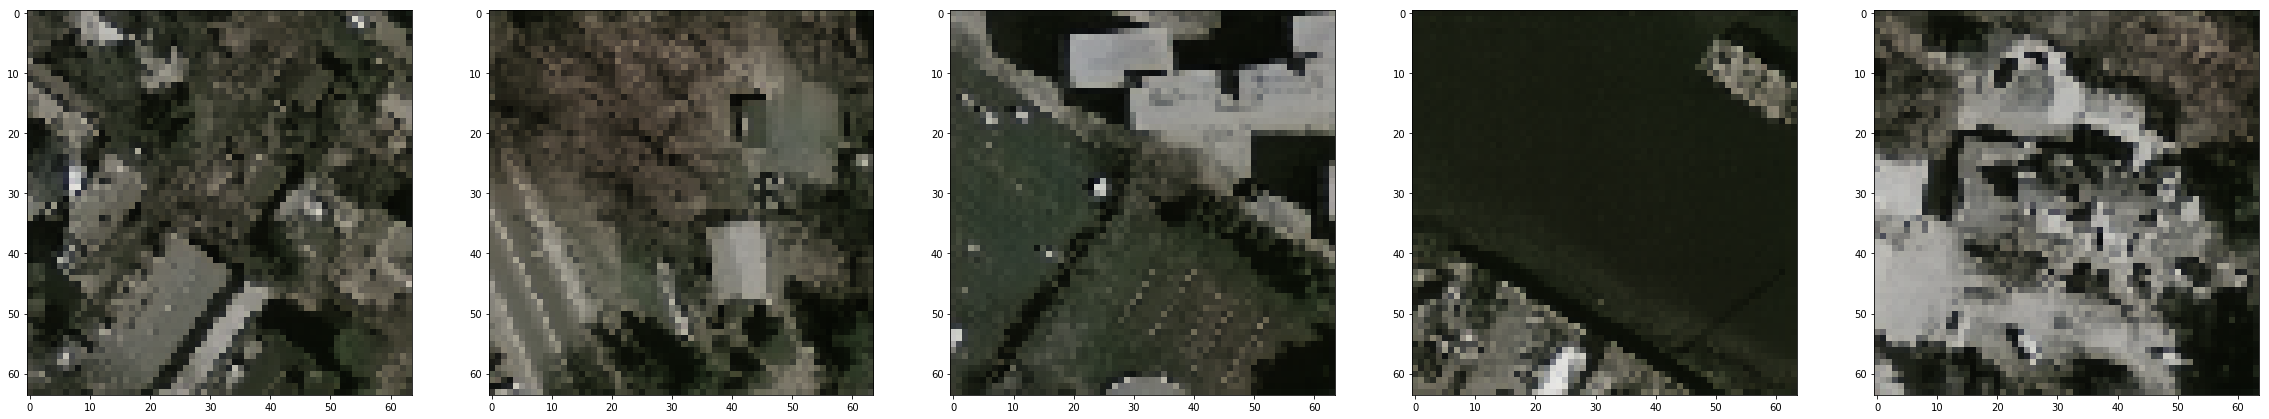

In [293]:
show_chips(S)

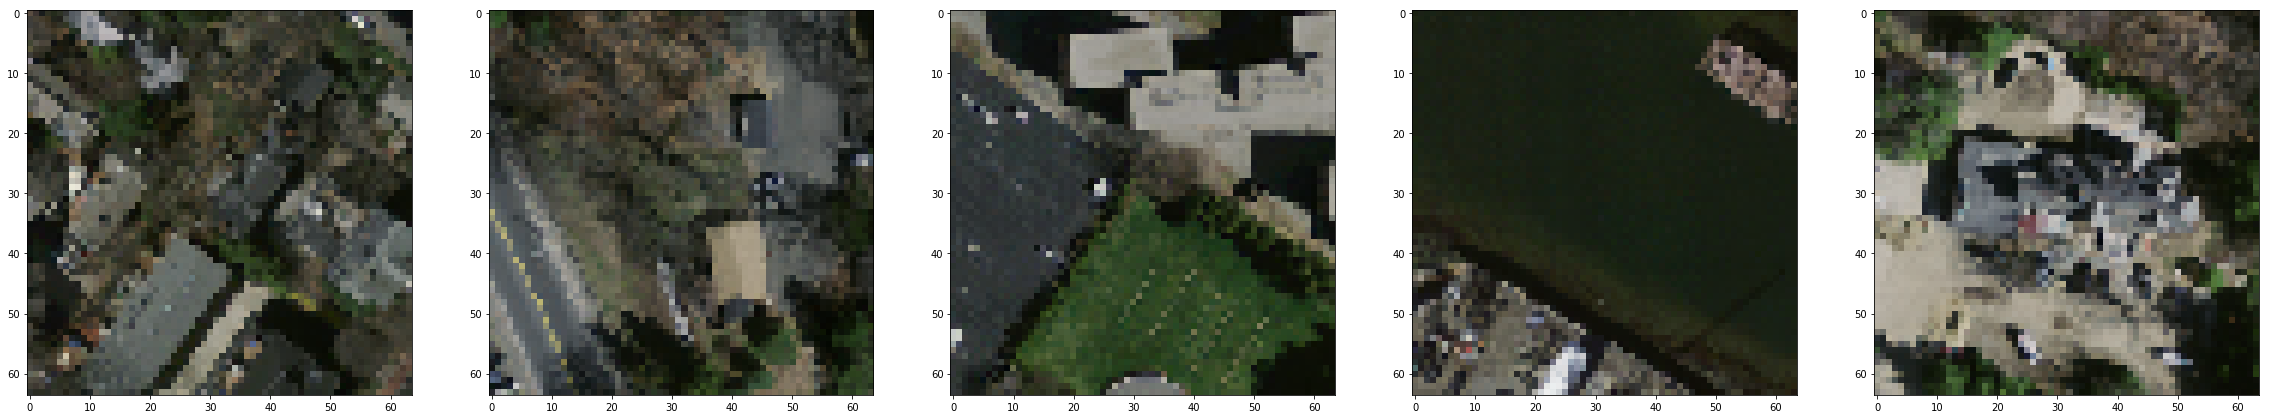

In [294]:
show_chips(X)

# U-Net as Autoencoder

In [300]:
X, X = next(ae_gen)

In [301]:
unet_ae = UNet(X[0].shape)

In [303]:
unet_ae._model.fit_generator(ae_gen, steps_per_epoch=100, epochs=10)

Epoch 1/10
100/100 [==============================] - 8s 75ms/step - loss: 0.0183
Epoch 2/10
100/100 [==============================] - 4s 37ms/step - loss: 0.0019
Epoch 3/10
100/100 [==============================] - 4s 37ms/step - loss: 7.9022e-04
Epoch 4/10
100/100 [==============================] - 4s 37ms/step - loss: 5.9687e-04
Epoch 5/10
100/100 [==============================] - 4s 37ms/step - loss: 4.4347e-04
Epoch 6/10
100/100 [==============================] - 4s 37ms/step - loss: 3.7394e-04
Epoch 7/10
100/100 [==============================] - 4s 37ms/step - loss: 4.3370e-04
Epoch 8/10
100/100 [==============================] - 4s 37ms/step - loss: 3.1835e-04
Epoch 9/10
100/100 [==============================] - 4s 38ms/step - loss: 2.9344e-04
Epoch 10/10
100/100 [==============================] - 4s 37ms/step - loss: 3.1573e-04


In [305]:
Y = unet_ae._model.predict(X)

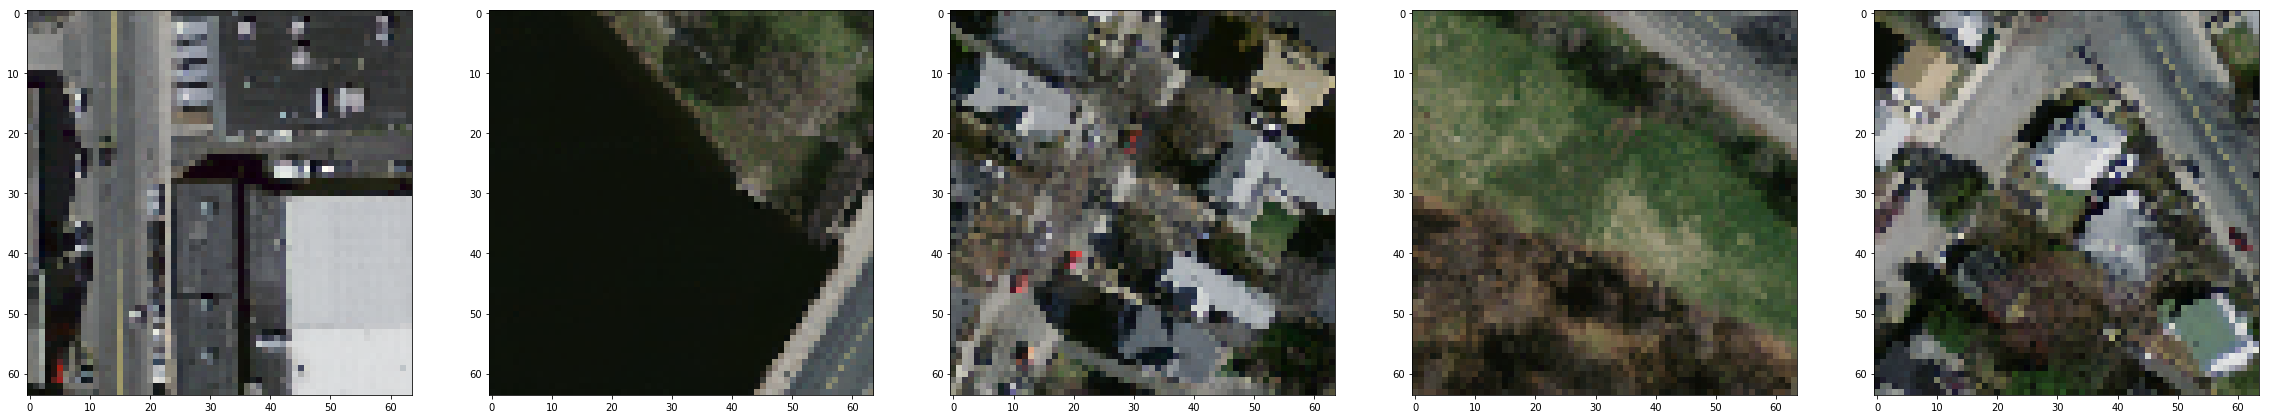

In [306]:
show_chips(X)

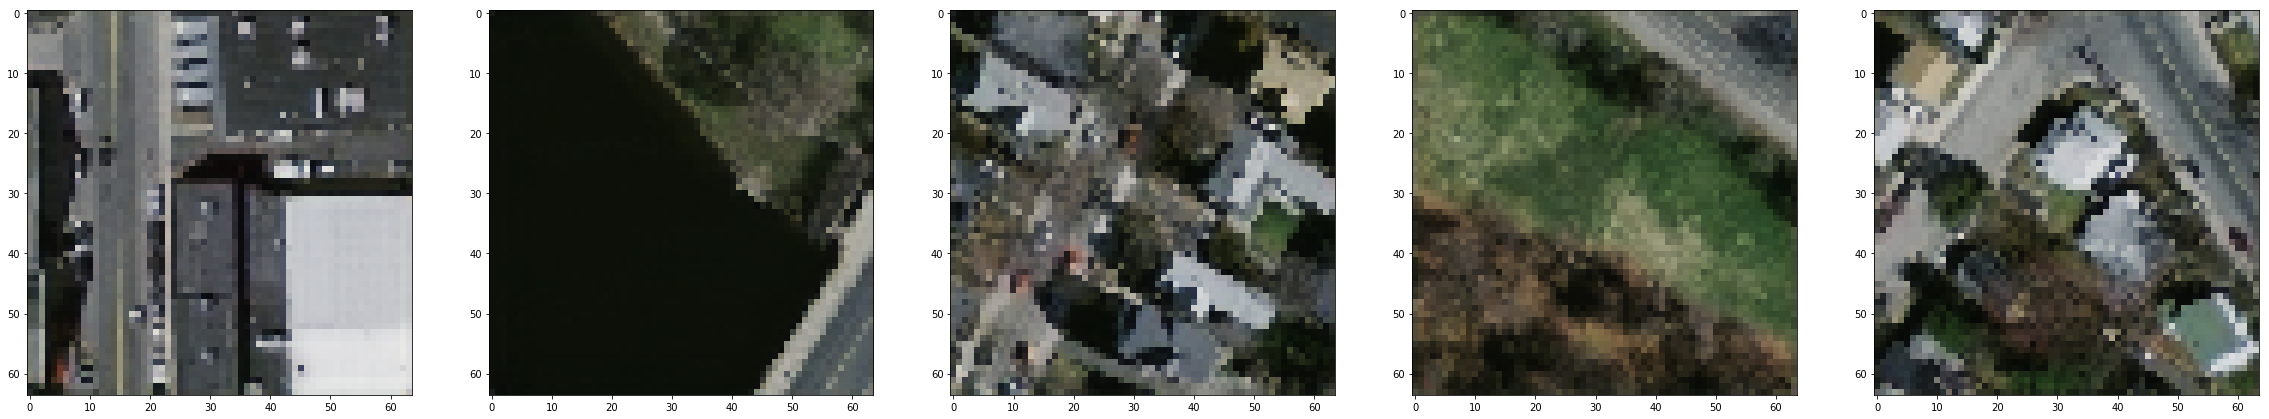

In [307]:
show_chips(Y)

# VDSR: Very Deep Super Resolution

![](https://cdn-images-1.medium.com/max/1200/1*1JbheZVd8ixUPXm1ilQu3Q.png)

In [180]:
from skimage.transform import resize

In [259]:
def VDSR(inshape):
    I = Input(inshape)
    x = I
    
    for _ in range(19):
        x = Conv2D(64, kernel_size=3, padding="same")(x)
        x = Activation("relu")(x)
        
    x = Conv2D(3, kernel_size=3, padding="same")(x)
    x = Activation("tanh")(x)
    
    model = Model(inputs=I, outputs=x)
    model.compile(loss="mean_squared_error", optimizer=Adam(0.001))
    
    return model

In [240]:
def lr_hr_generator(base_gen):
    def downsample(X):
        h, w, c = X.shape
        return resize(X, (h//2, w//2, c), anti_aliasing=True, order=1, mode="reflect")
    
    def upsample(X):
        h, w, c = X.shape
        return resize(X, (h*2, w*2, c), anti_aliasing=True, order=1, mode="reflect")
    
    for hr in base_gen:
        # Downsample then upsample
        lr = np.array([upsample(downsample(x)) for x in hr])
        yield lr, hr

In [241]:
def residual_generator(lr_hr_gen):
    for lr, hr in lr_hr_gen:
        yield lr, hr-lr

In [242]:
lr_hr_gen = lr_hr_generator(chip_gen)

In [243]:
lr, hr = next(lr_hr_gen)

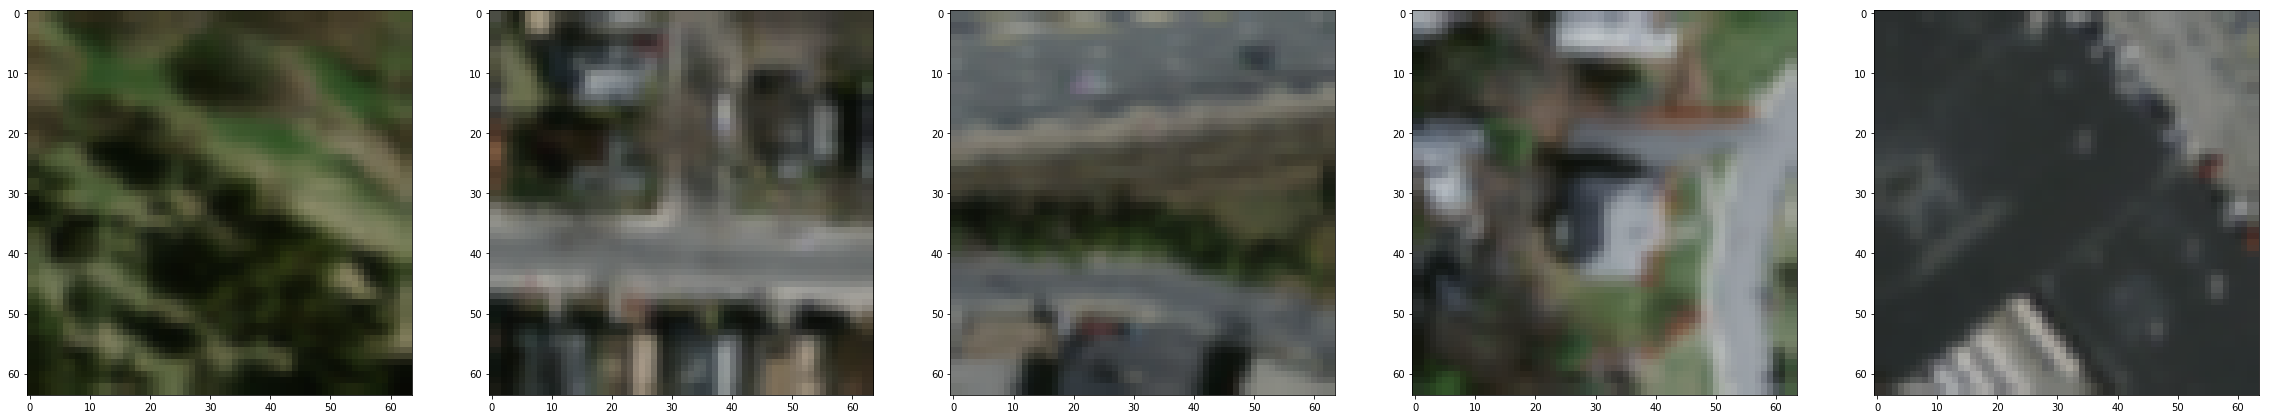

In [244]:
show_chips(lr)

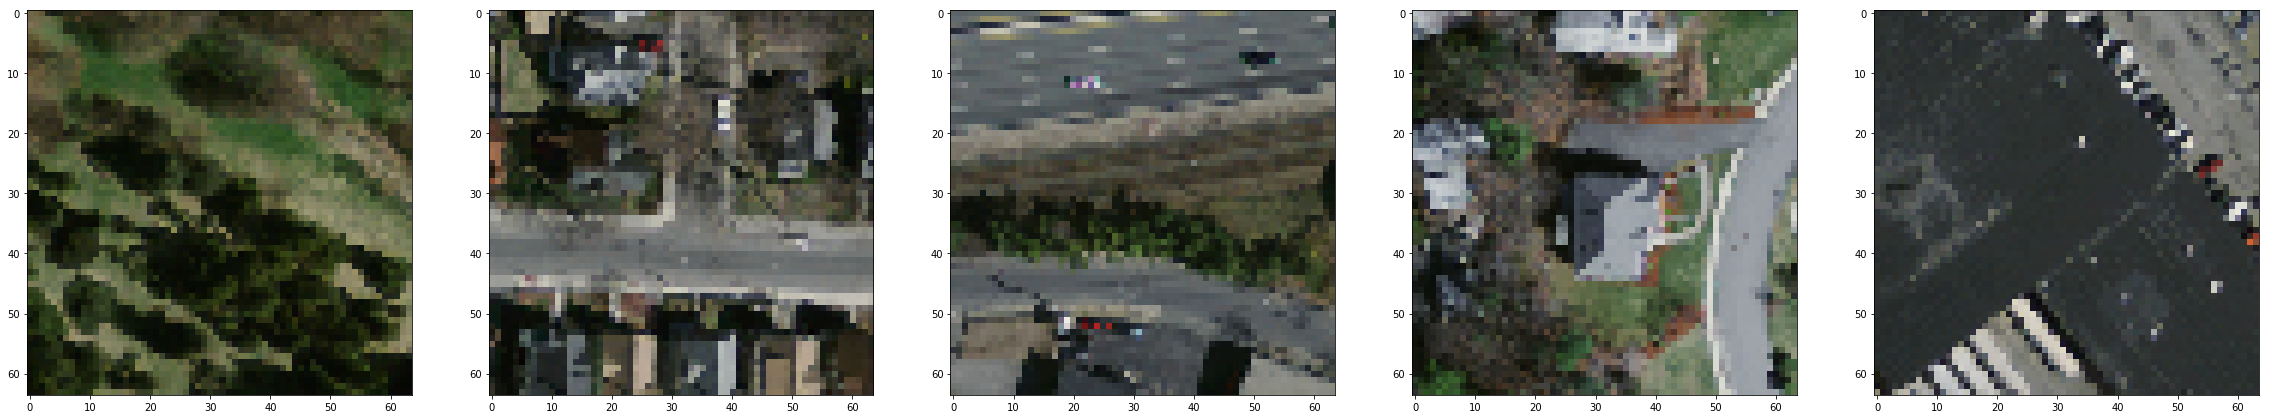

In [245]:
show_chips(hr)

In [246]:
res_gen = residual_generator(lr_hr_gen)

In [247]:
lr, lr_res = next(res_gen)

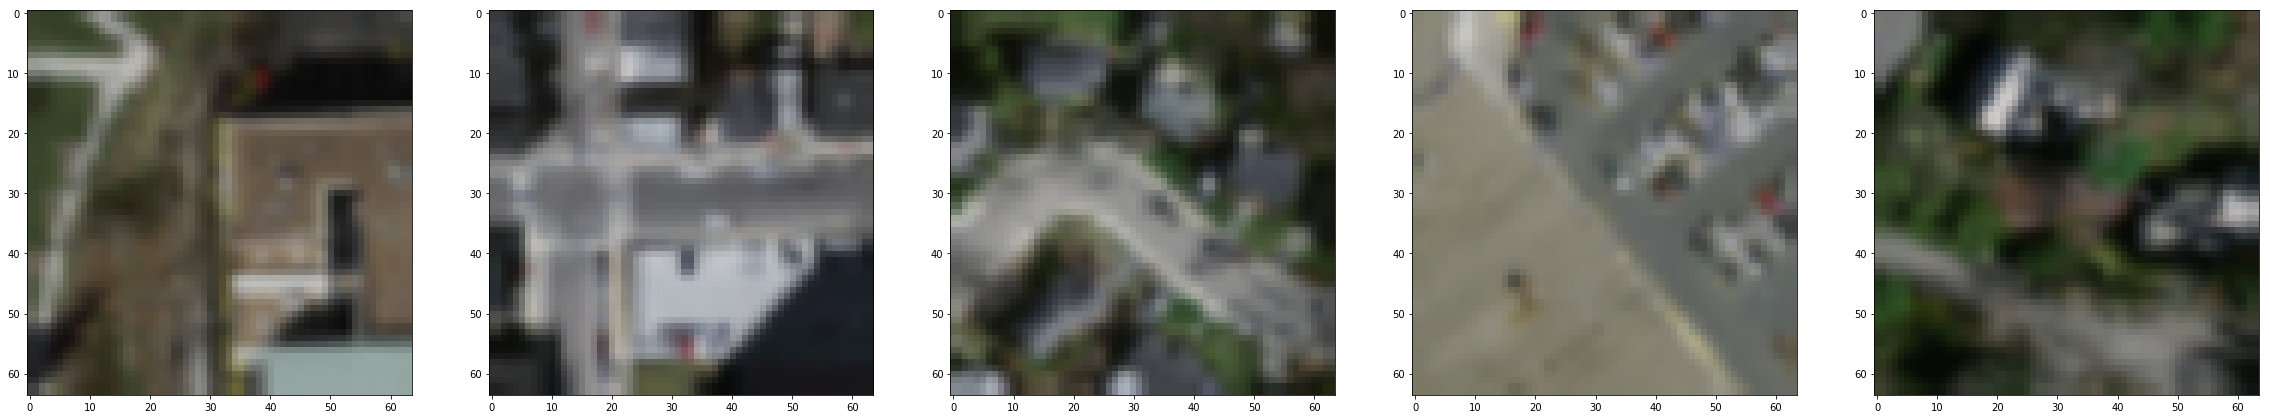

In [248]:
show_chips(lr)

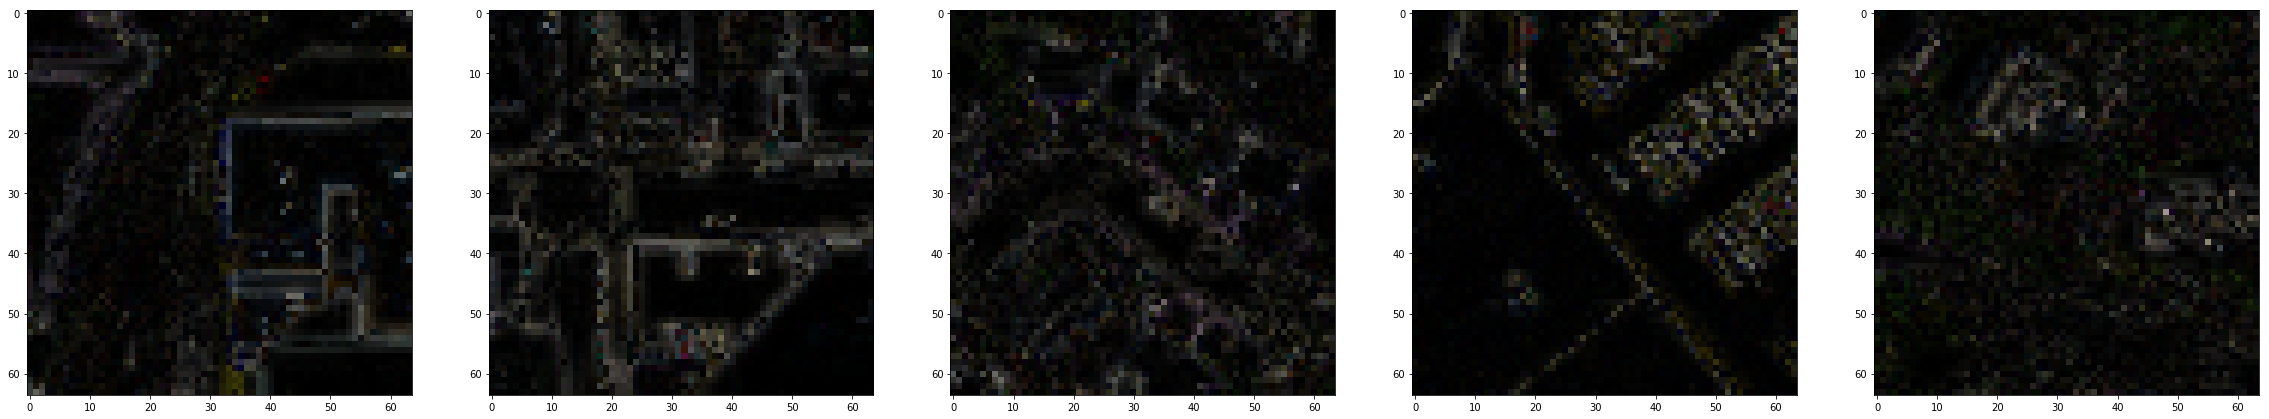

In [249]:
show_chips(np.abs(lr_res))

In [260]:
vdsr = VDSR(lr[0].shape)

In [261]:
vdsr.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_318 (Conv2D)          (None, 64, 64, 64)        1792      
_________________________________________________________________
activation_247 (Activation)  (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_319 (Conv2D)          (None, 64, 64, 64)        36928     
_________________________________________________________________
activation_248 (Activation)  (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_320 (Conv2D)          (None, 64, 64, 64)        36928     
_________________________________________________________________
activation_249 (Activation)  (None, 64, 64, 64)        0         
__________

In [262]:
vdsr.fit_generator(res_gen, steps_per_epoch=100, epochs=10)

Epoch 1/10
100/100 [==============================] - 11s 110ms/step - loss: 0.0048
Epoch 2/10
100/100 [==============================] - 7s 72ms/step - loss: 0.0038
Epoch 3/10
100/100 [==============================] - 7s 70ms/step - loss: 0.0036
Epoch 4/10
100/100 [==============================] - 7s 71ms/step - loss: 0.0035
Epoch 5/10
100/100 [==============================] - 7s 69ms/step - loss: 0.0035
Epoch 6/10
100/100 [==============================] - 7s 70ms/step - loss: 0.0035
Epoch 7/10
100/100 [==============================] - 7s 69ms/step - loss: 0.0035
Epoch 8/10
100/100 [==============================] - 7s 69ms/step - loss: 0.0035
Epoch 9/10
100/100 [==============================] - 7s 70ms/step - loss: 0.0034
Epoch 10/10
100/100 [==============================] - 7s 71ms/step - loss: 0.0034


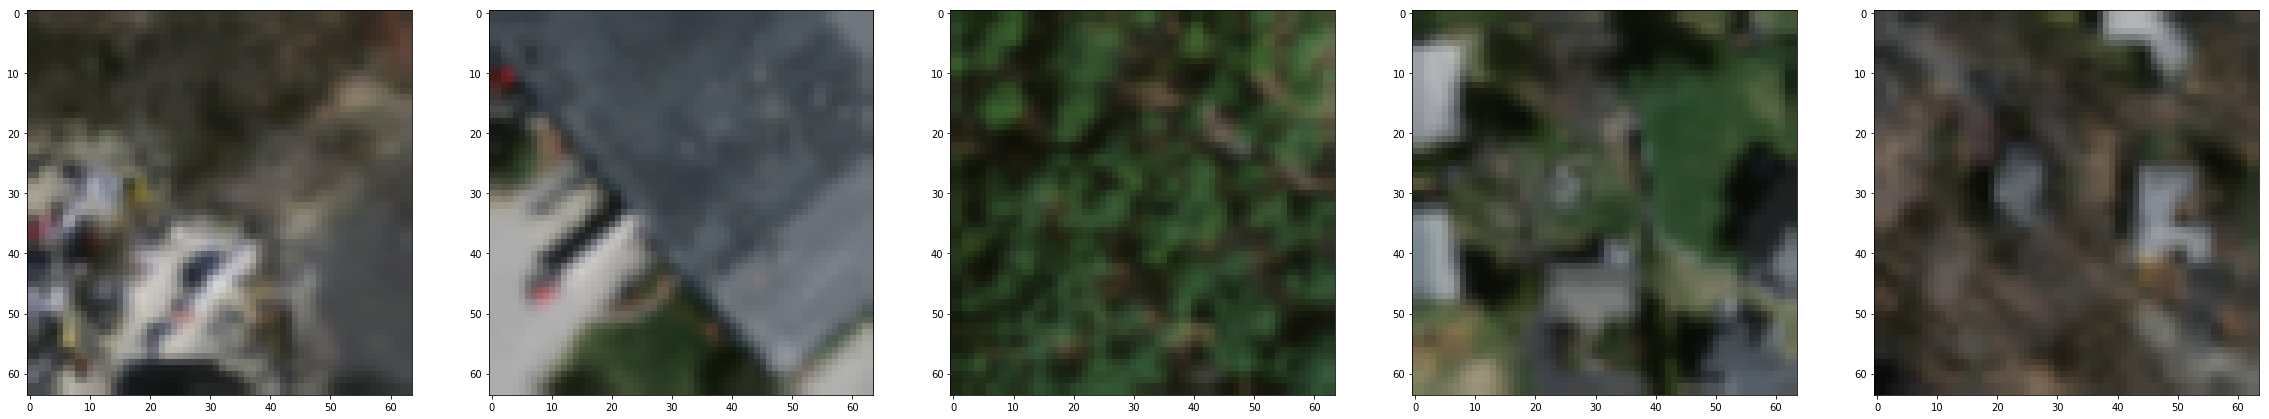

In [272]:
lr, hr = next(lr_hr_gen)
show_chips(lr)

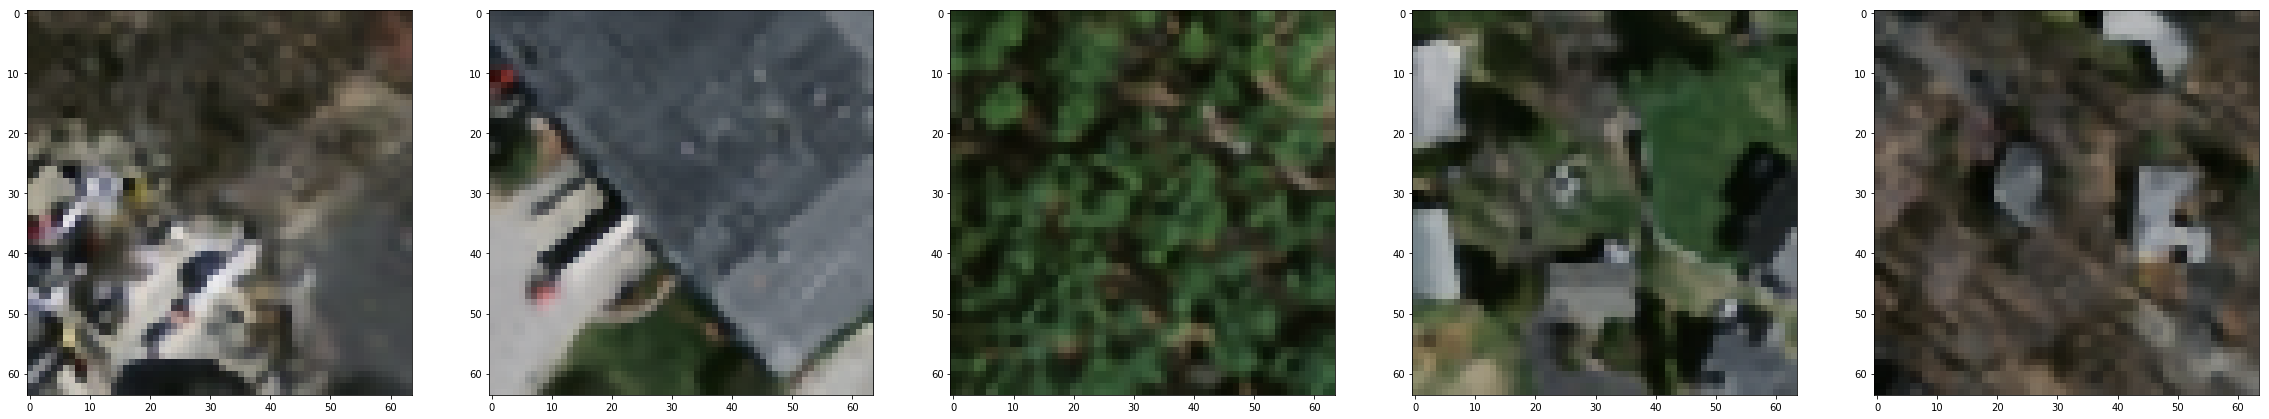

In [273]:
R = vdsr.predict(lr)
hr_approx = lr + R
hr_approx = np.clip(hr_approx, 0, 1)
show_chips(hr_approx)

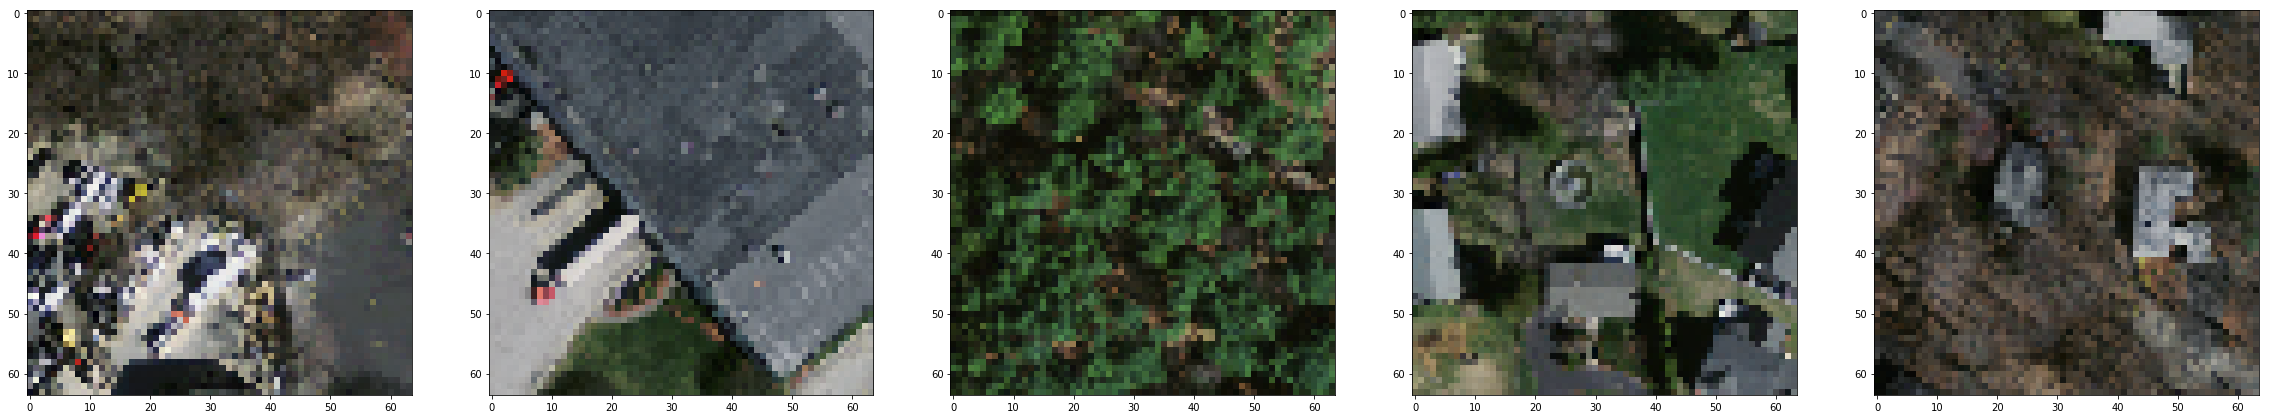

In [274]:
show_chips(hr)